In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.cluster import KMeans
import tensorflow as tf
import random
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

In [5]:
data = pd.read_csv('/content/Fraud.csv')

In [6]:
data.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0

In [7]:
data.isna().sum().sum()

2

In [8]:
rows_with_nulls = data[data.isnull().any(axis=1)]
print(rows_with_nulls)

        step     type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
216814    13  CASH_IN  196627.14  C2004365456        19890.0       216517.14   

           nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
216814  C2132646226        65135.73          2254.0      NaN             NaN  


Since the isFraud and isFlaggedFraud is empty we can drop it


In [9]:
data = data.dropna(subset=['isFraud'])

In [10]:
duplicate_data = data[data.duplicated(keep=False)]
print(duplicate_data)

Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


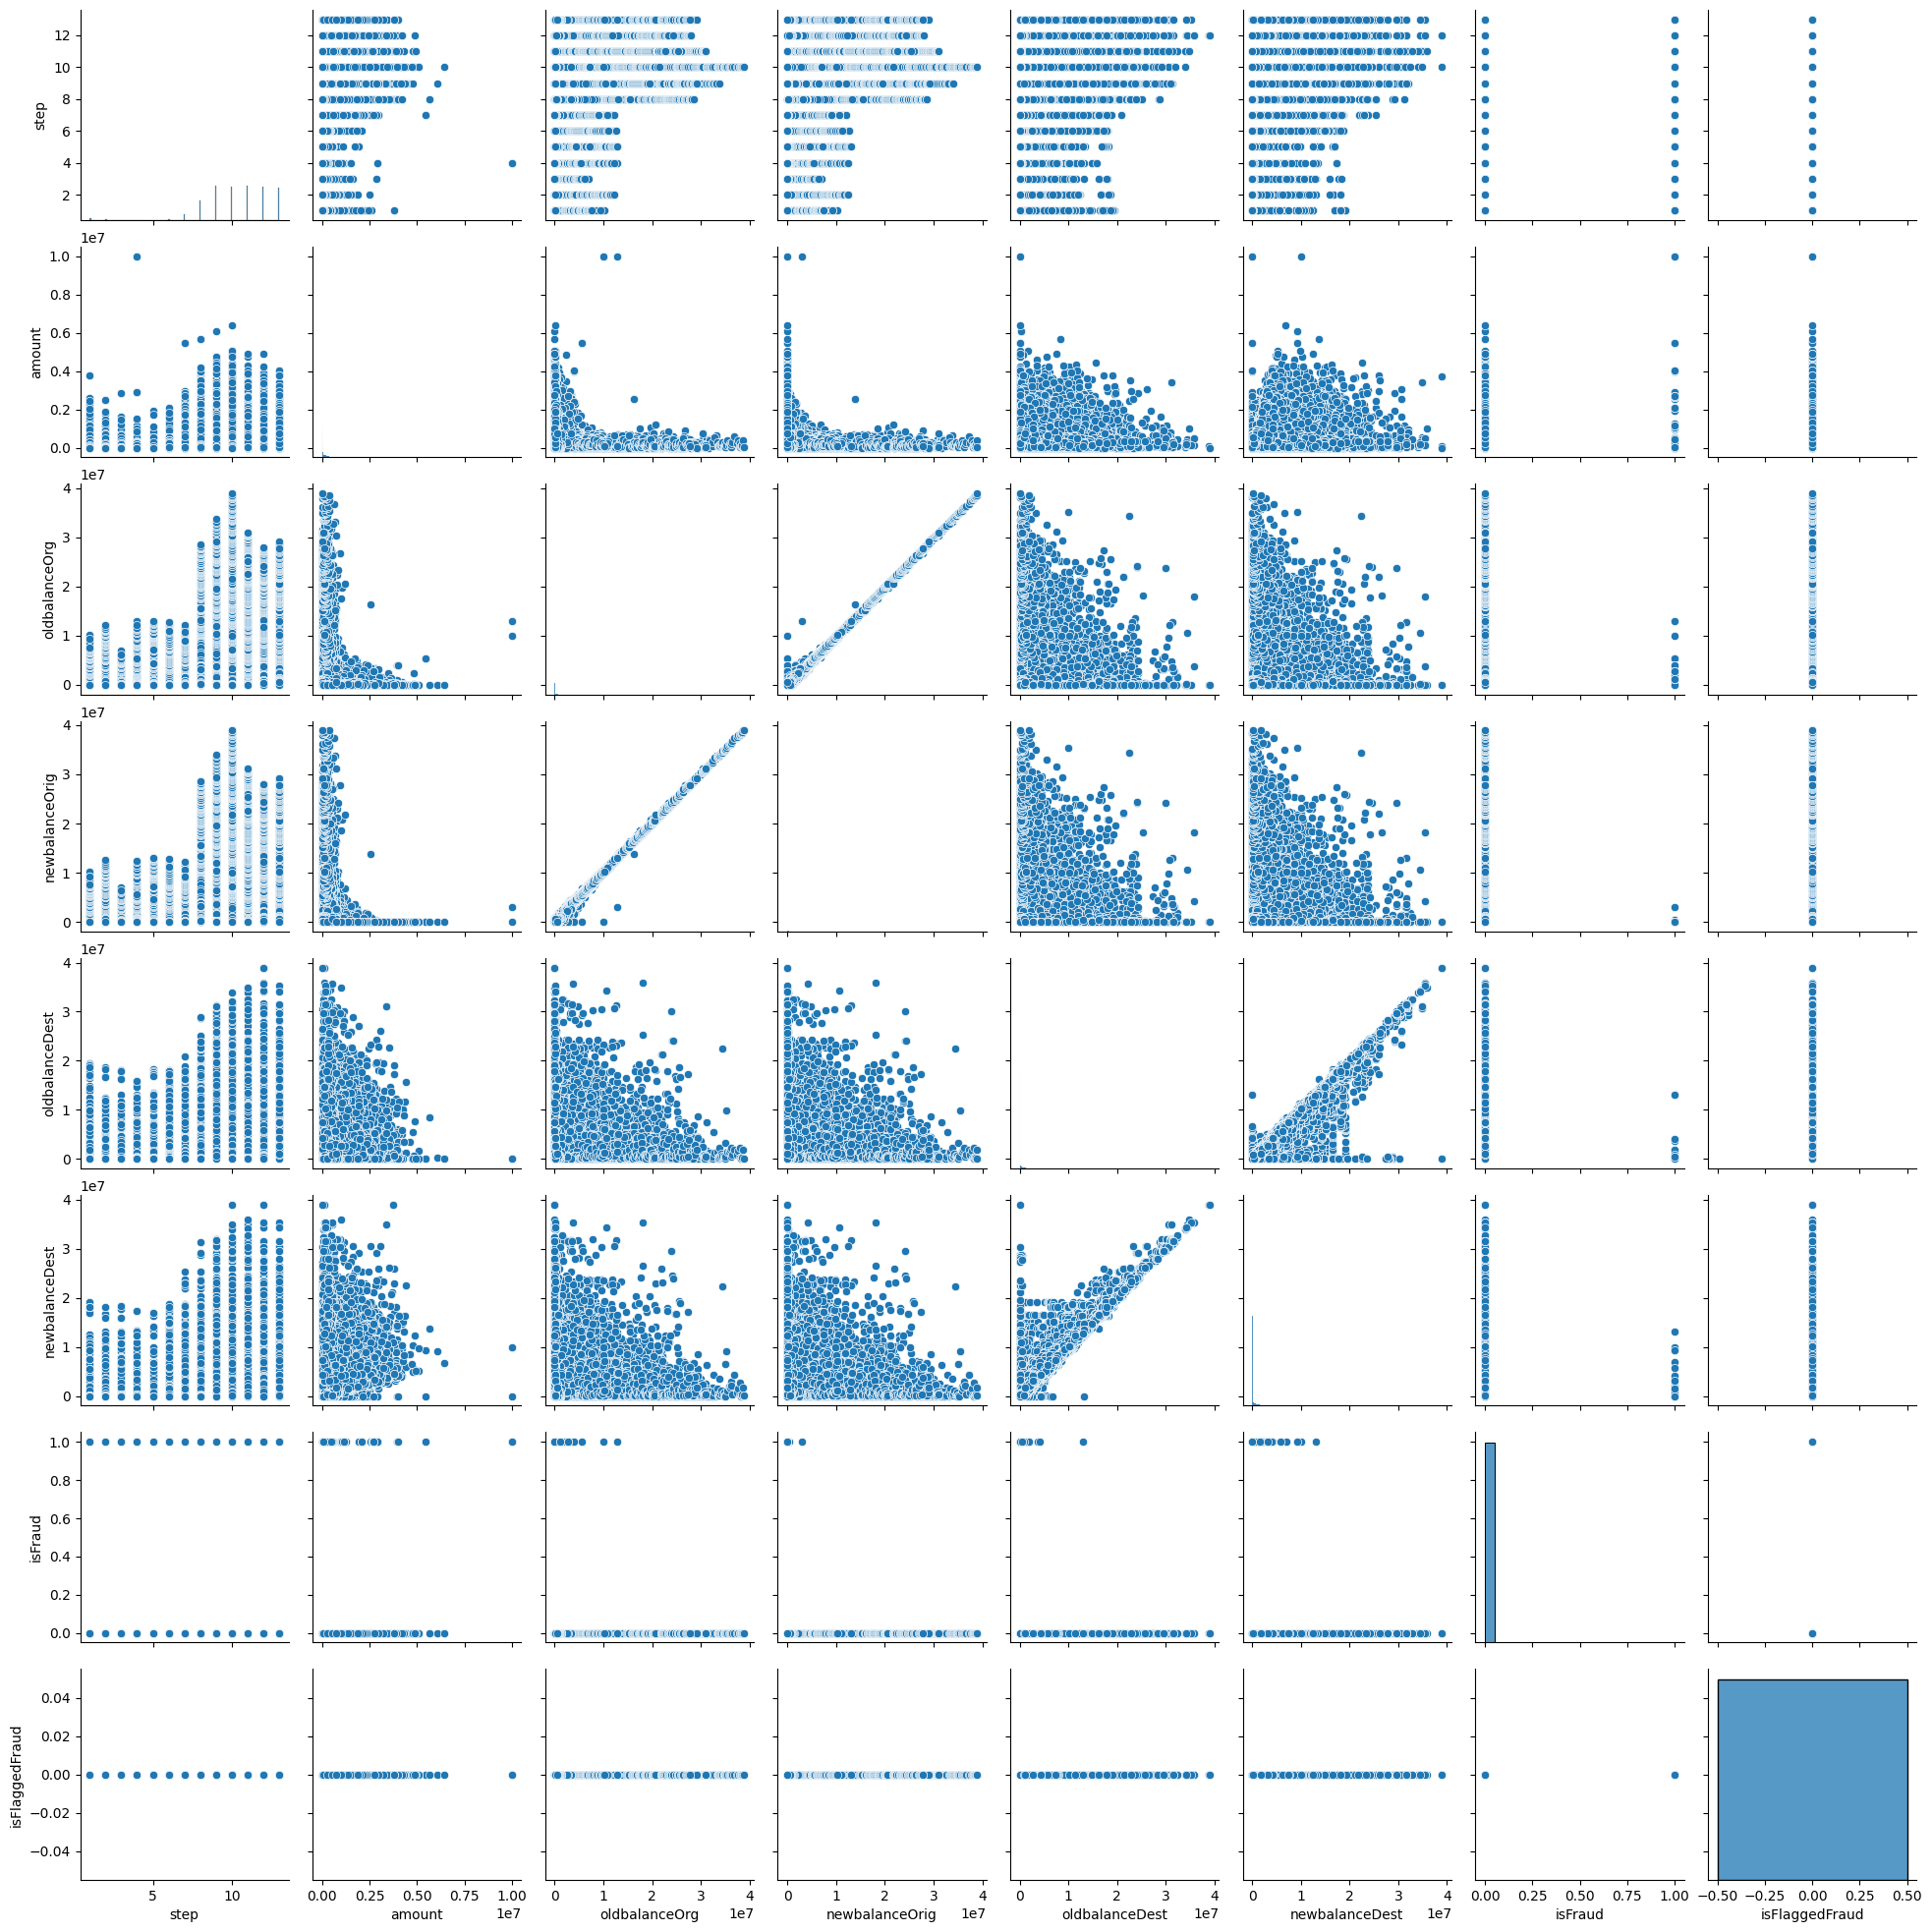

In [11]:
subset_data = data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

sns.pairplot(data)
plt.show()

oldbalanceOrg vs newbalanceOrg is linear in nature

oldbalanceDest vs newbalanceDest shows linear relationship, but the concentration of datapoints is high in the lower region

In the rest of the graph, most of the datapoints lies in the lower region, which shows non-linearity

In [12]:
#Checking for skewness

skewness = subset_data.skew()
print("Skewness of each column:")
print(skewness)

Skewness of each column:
amount            5.010276
oldbalanceOrg     5.180511
newbalanceOrig    5.109591
oldbalanceDest    5.093476
newbalanceDest    4.496602
dtype: float64


In [13]:
# From the graph we can say that these columns are right skewed, in order to bring down the skewness

data['amount'] = np.log1p(data['amount'])
data['oldbalanceOrg'] = np.log1p(data['oldbalanceOrg'])
data['newbalanceOrig'] = np.log1p(data['newbalanceOrig'])
data['oldbalanceDest'] = np.log1p(data['oldbalanceDest'])
data['newbalanceDest'] = np.log1p(data['newbalanceDest'])

In [14]:
subset_data_up = data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

skewness = subset_data_up.skew()
print("Skewness of each column:")
print(skewness)

Skewness of each column:
amount           -0.475610
oldbalanceOrg    -0.312973
newbalanceOrig    0.325007
oldbalanceDest   -0.139821
newbalanceDest   -0.210922
dtype: float64


Not removing outliners because, they are neccassry for fraud detection

In [15]:
data['step'] = data['step'].astype('category').cat.codes
data['type'] = data['type'].astype('category').cat.codes

Training a mini model to check if nameOrig column has any relation with isFraud

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

test_data = data.copy()
test_data['nameOrig'] = label_encoder.fit_transform(test_data['nameOrig'])
test_data['nameDest'] = label_encoder.fit_transform(test_data['nameDest'])

X = test_data.drop('isFraud', axis=1)
y = test_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

importance = model.feature_importances_

feature_names = X.columns

for name, score in zip(feature_names, importance):
    print(f'{name:15}: {score:.8f}')


step           : 0.05595306
type           : 0.02944439
amount         : 0.20912136
nameOrig       : 0.08630524
oldbalanceOrg  : 0.20097514
newbalanceOrig : 0.02886828
nameDest       : 0.10458360
oldbalanceDest : 0.14746093
newbalanceDest : 0.13728798
isFlaggedFraud : 0.00000000


In [17]:
test_data.head()

step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     0     3  9.194276     25899      12.044359       11.984786     62920   
1     0     3  7.531166     74328       9.964112        9.872292     65509   
2     0     4  5.204007     34079       5.204007        0.000000     17532   
3     0     1  5.204007    198783       5.204007        0.000000     15598   
4     0     3  9.364703    116981      10.634773       10.305174     32125   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0        0.000000             0.0      0.0             0.0  
1        0.000000             0.0      0.0             0.0  
2        0.000000             0.0      1.0             0.0  
3        9.960954             0.0      1.0             0.0  
4        0.000000             0.0      0.0             0.0

In [18]:
data.head()

step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     0     3  9.194276  C1231006815      12.044359       11.984786   
1     0     3  7.531166  C1666544295       9.964112        9.872292   
2     0     4  5.204007  C1305486145       5.204007        0.000000   
3     0     1  5.204007   C840083671       5.204007        0.000000   
4     0     3  9.364703  C2048537720      10.634773       10.305174   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155        0.000000             0.0      0.0             0.0  
1  M2044282225        0.000000             0.0      0.0             0.0  
2   C553264065        0.000000             0.0      1.0             0.0  
3    C38997010        9.960954             0.0      1.0             0.0  
4  M1230701703        0.000000             0.0      0.0             0.0

In [19]:
'''The columns nameOrig_encoded and nameOrig_target_encoded are not neccasary since, nameOrig_target_encoded is a direct reference from the target
column, and nameOrig_encoded is just a copy of nameOrig '''

#test_data = test_data.drop('nameOrig_encoded', axis=1)
#test_data = test_data.drop('nameOrig_target_encoded', axis=1)

data = test_data

data.head()

step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     0     3  9.194276     25899      12.044359       11.984786     62920   
1     0     3  7.531166     74328       9.964112        9.872292     65509   
2     0     4  5.204007     34079       5.204007        0.000000     17532   
3     0     1  5.204007    198783       5.204007        0.000000     15598   
4     0     3  9.364703    116981      10.634773       10.305174     32125   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0        0.000000             0.0      0.0             0.0  
1        0.000000             0.0      0.0             0.0  
2        0.000000             0.0      1.0             0.0  
3        9.960954             0.0      1.0             0.0  
4        0.000000             0.0      0.0             0.0

In [20]:
for name, score in zip(feature_names, importance):
    print(f'{name:15}: {score:.8f}')

step           : 0.05595306
type           : 0.02944439
amount         : 0.20912136
nameOrig       : 0.08630524
oldbalanceOrg  : 0.20097514
newbalanceOrig : 0.02886828
nameDest       : 0.10458360
oldbalanceDest : 0.14746093
newbalanceDest : 0.13728798
isFlaggedFraud : 0.00000000


In [21]:
'''Since isFlaggedFraud's importance is 0, we can remove it'''

data = data.drop('isFlaggedFraud', axis=1)
data.head()

step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     0     3  9.194276     25899      12.044359       11.984786     62920   
1     0     3  7.531166     74328       9.964112        9.872292     65509   
2     0     4  5.204007     34079       5.204007        0.000000     17532   
3     0     1  5.204007    198783       5.204007        0.000000     15598   
4     0     3  9.364703    116981      10.634773       10.305174     32125   

   oldbalanceDest  newbalanceDest  isFraud  
0        0.000000             0.0      0.0  
1        0.000000             0.0      0.0  
2        0.000000             0.0      1.0  
3        9.960954             0.0      1.0  
4        0.000000             0.0      0.0

In [22]:
'''newbalanceOrig has very less importance, so instead of removing, find the difference between newbalanceOrig and oldbalanceDest might have some impact'''

#Feature Eng

data['newbalanceOrig_diff'] = data['newbalanceOrig'] - data['oldbalanceDest']
data = data.drop('newbalanceOrig', axis=1)
data = data.drop('oldbalanceDest', axis=1)
data.head()

skewness = skew(data['newbalanceOrig_diff'])
print(f'Skewness: {skewness}\n')

Skewness: -0.02238204694605258



In [23]:
'''Traning once more to re-evaluate'''

test_data = data

X = test_data.drop('isFraud', axis=1)
y = test_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

importance = model.feature_importances_

feature_names = X.columns

for name, score in zip(feature_names, importance):
    print(f'{name:15}: {score:.8f}')


step           : 0.07201362
type           : 0.03654687
amount         : 0.21193984
nameOrig       : 0.10393360
oldbalanceOrg  : 0.16006994
nameDest       : 0.10337978
newbalanceDest : 0.16801941
newbalanceOrig_diff: 0.14409694


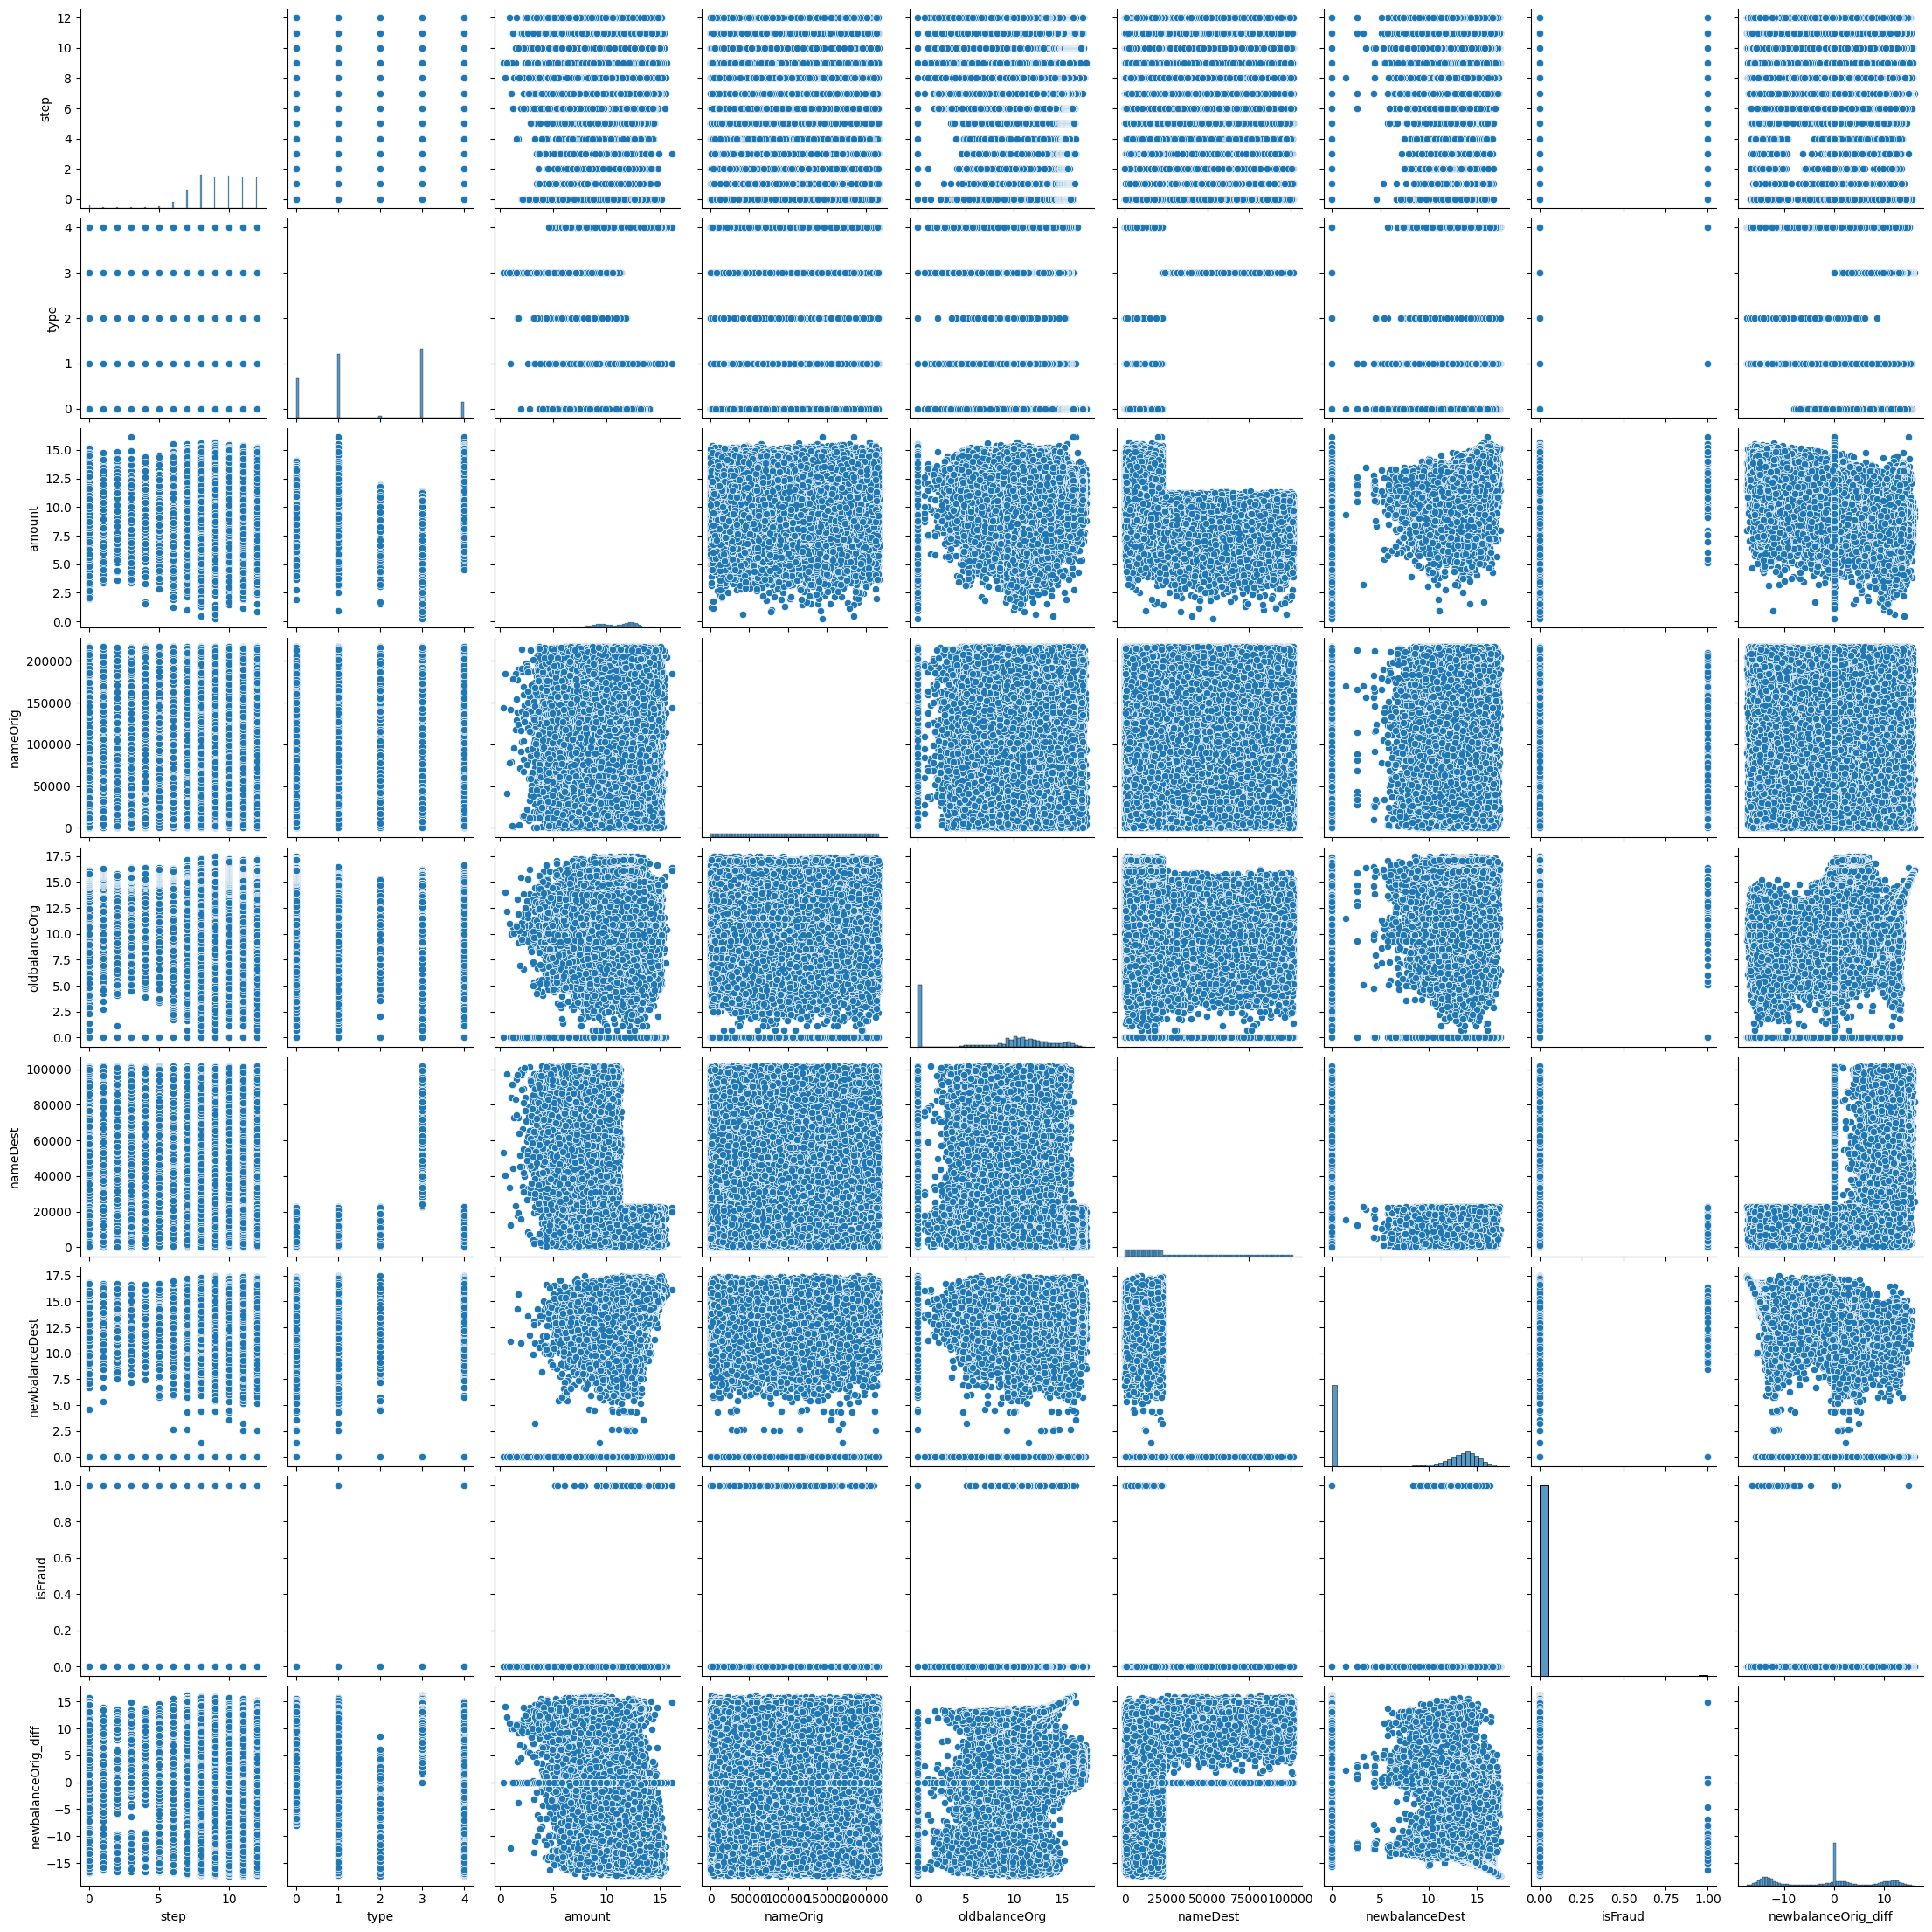

In [24]:
sns.pairplot(data)
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


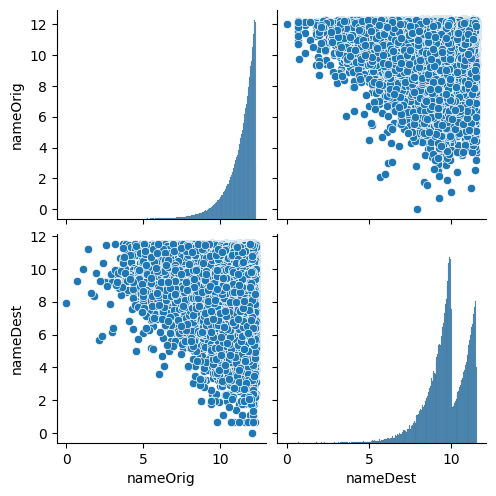

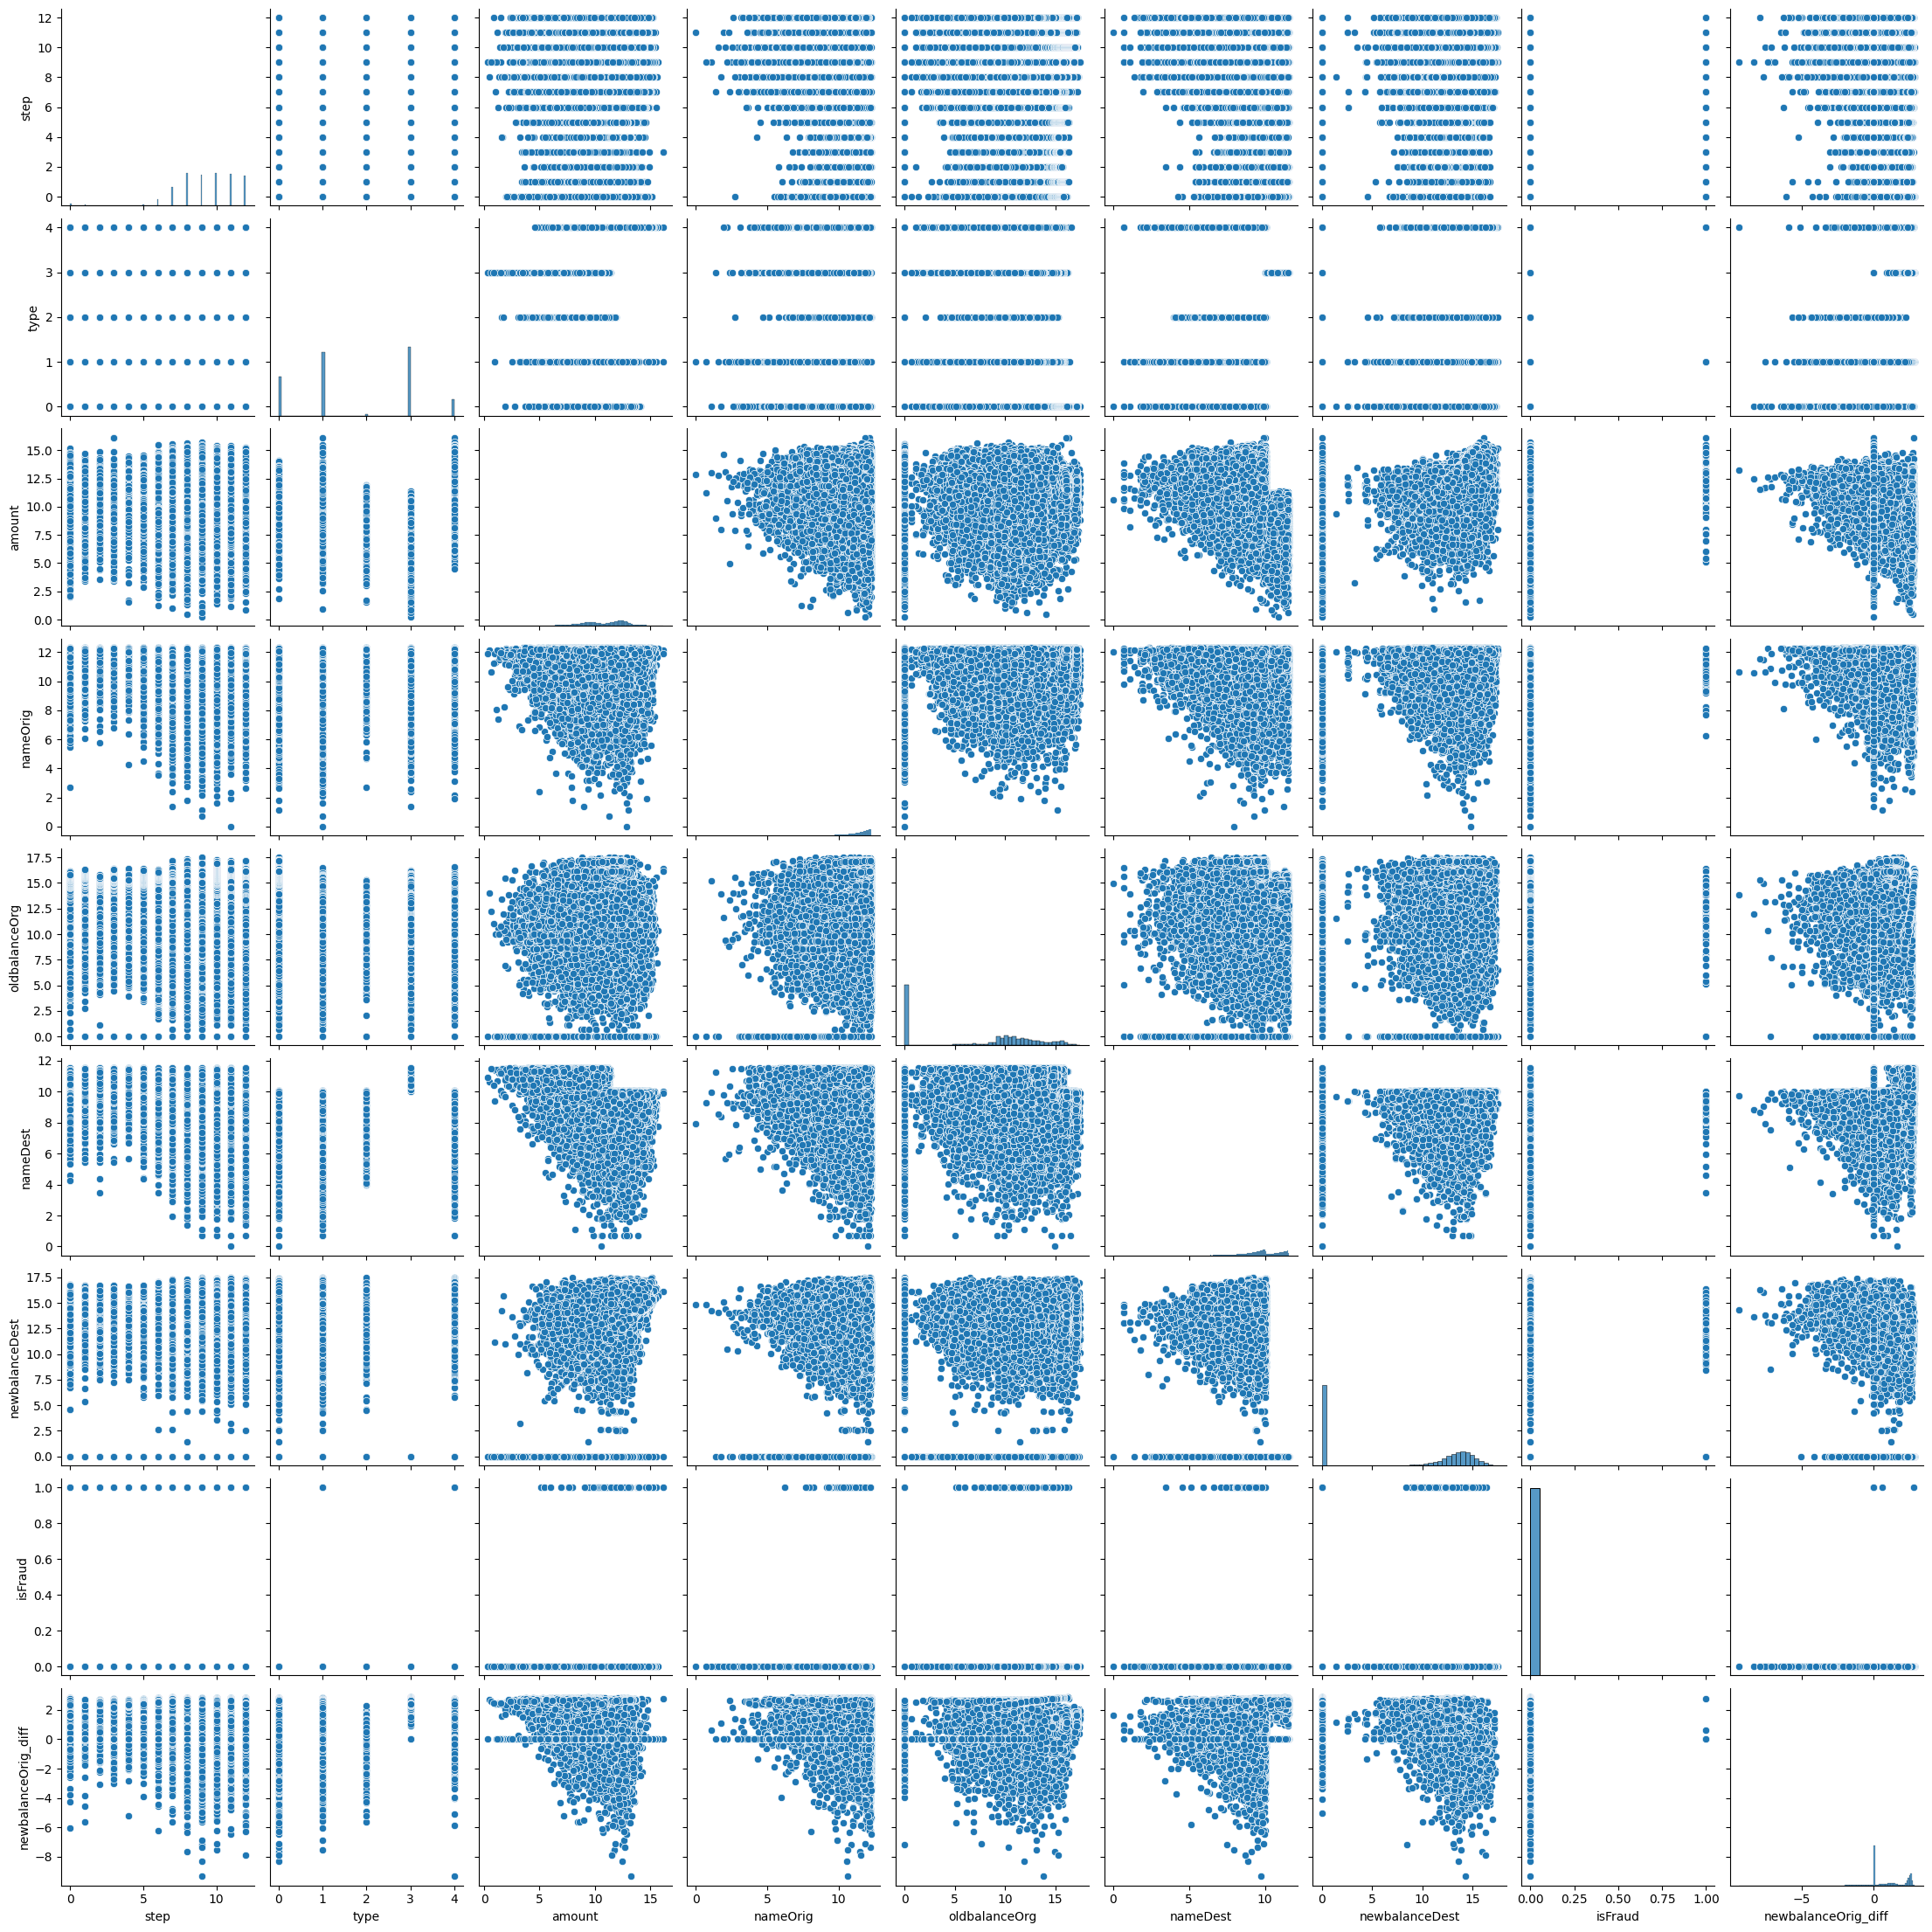

In [25]:
'''Since nameOrig, nameDest and newbalanceOrig_diff is extremely scattered'''

sample_data = data

sample_data['nameOrig'] = np.log1p(sample_data['nameOrig'])
sample_data['nameDest'] = np.log1p(sample_data['nameDest'])
sample_data['newbalanceOrig_diff'] = np.log1p(sample_data['newbalanceOrig_diff'])

def add_jitter(arr, noise_level=0.01):
    return arr + noise_level * np.random.randn(len(arr))

sample_data['nameOrig'] = add_jitter(sample_data['nameOrig'])
sample_data['nameDest'] = add_jitter(sample_data['nameDest'])

sns.pairplot(sample_data[['nameOrig', 'nameDest']])
plt.show()


sns.pairplot(sample_data)
plt.show()

Skewness: -1.9958202407463475



Text(0.5, 1.0, 'nameOrig Box Plot')

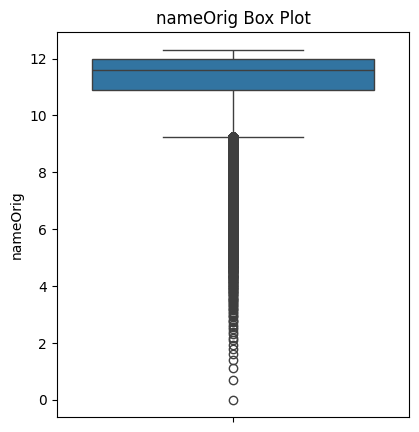

In [26]:
skewness = skew(sample_data['nameOrig'])
print(f'Skewness: {skewness}\n')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=sample_data['nameOrig'])
plt.title("nameOrig Box Plot")

Skewness: -0.9746013677754022



Text(0.5, 1.0, 'nameOrig Box Plot')

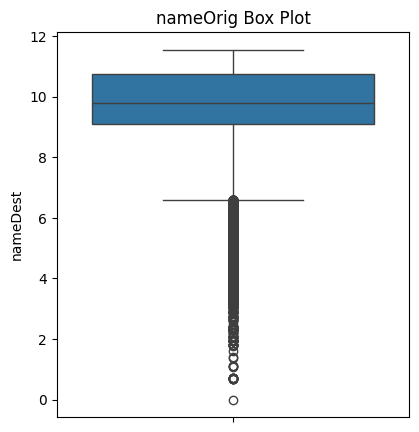

In [27]:
skewness = skew(sample_data['nameDest'])
print(f'Skewness: {skewness}\n')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=sample_data['nameDest'])
plt.title("nameOrig Box Plot")

Skewness: nan



Text(0.5, 1.0, 'nameOrig Box Plot')

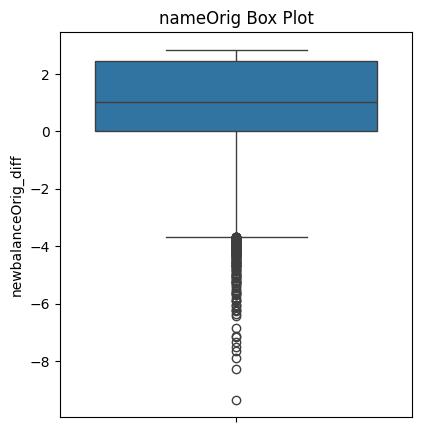

In [28]:
skewness = skew(sample_data['newbalanceOrig_diff'])
print(f'Skewness: {skewness}\n')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=sample_data['newbalanceOrig_diff'])
plt.title("nameOrig Box Plot")

We are not doing anything to high skewness of nameOrig and nameDest, since the skewness might help in identifying fraud

Investigating why skewness of 'newbalanceOrig_diff' is showing NaN

In [29]:
print(sample_data['newbalanceOrig_diff'].isnull().sum())

82961


Shows almost 10% of the column is null, have to deal with it by adding median beacuse there lies significant outliners, shown in the figure

Training a model to check the newbalanceOrig_diff importance

In [30]:
median_value = sample_data['newbalanceOrig_diff'].median()

mean_value = sample_data['newbalanceOrig_diff'].mean()

sample_data['newbalanceOrig_diff'].fillna(median_value, inplace=True)

In [31]:
data['newbalanceOrig_diff'].head()

0    2.563778
1    2.386218
2    0.000000
3    1.039486
4    2.425261
Name: newbalanceOrig_diff, dtype: float64

In [32]:
skewness = skew(sample_data['newbalanceOrig_diff'])
print(f'Skewness: {skewness}\n')

Skewness: -0.1542706171610982



Skewness of newbalanceOrig_diff has been reduced significantly, so now we can move on with model traning

In [33]:
data = sample_data

In [34]:
y = data['isFraud']
X = data.drop('isFraud', axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(8,)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') ])

In [38]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

In [40]:
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
19514/19514 [==============================] - 62s 3ms/step - loss: 0.0099 - accuracy: 0.9992 - val_loss: 0.0066 - val_accuracy: 0.9993
Epoch 2/10
19514/19514 [==============================] - 53s 3ms/step - loss: 0.0067 - accuracy: 0.9993 - val_loss: 0.0062 - val_accuracy: 0.9993
Epoch 3/10
19514/19514 [==============================] - 55s 3ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.0065 - val_accuracy: 0.9993
Epoch 4/10
19514/19514 [==============================] - 56s 3ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0.0060 - val_accuracy: 0.9993
Epoch 5/10
19514/19514 [==============================] - 56s 3ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0.0066 - val_accuracy: 0.9993
Epoch 6/10
19514/19514 [==============================] - 56s 3ms/step - loss: 0.0064 - accuracy: 0.9993 - val_loss: 0.0067 - val_accuracy: 0.9993
Epoch 7/10
19514/19514 [==============================] - 52s 3ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0

In [41]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1356/1356 [==============================] - 2s 2ms/step - loss: 0.0069 - accuracy: 0.9992
Test loss: 0.006920016370713711
Test Accuracy: 0.9992389678955078
